# Statistical Solution of CityLearn-2022-challenge
The CityLearn Challenge 2022 tasks us with optimally controlling the charge state for multiple buildings.
For the public training dataset of 5 buildings, we know everything and it should be possible to derive an optimal policy.
All 5 buildings can be solved independently, since the overall evaluation metric is just the sum of individual parts.

We want to minimize the sum of normalized energy use from the grid and normalized co2 emissions. These metrics can both be combined into a single function.

These quantities can be computed quickly from the time series of charge state, which depends on the actions and model constraints (like environment-dependent efficiency and power limits.)

In [192]:
# canonical imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# let's read in the data (this would probably be easier in SQL, but I don't want to set up a database)
# weather = pd.read_csv("data/citylearn_challenge_2022_phase_1/weather.csv")
# the buildings contain per-row time data
building1 = pd.read_csv("data/citylearn_challenge_2022_phase_1/Building_1.csv")
building2 = pd.read_csv("data/citylearn_challenge_2022_phase_1/Building_2.csv")
building3 = pd.read_csv("data/citylearn_challenge_2022_phase_1/Building_3.csv")
building4 = pd.read_csv("data/citylearn_challenge_2022_phase_1/Building_4.csv")
building5 = pd.read_csv("data/citylearn_challenge_2022_phase_1/Building_5.csv")

pricing = pd.read_csv("data/citylearn_challenge_2022_phase_1/pricing.csv")
co2 = pd.read_csv("data/citylearn_challenge_2022_phase_1/carbon_intensity.csv")

In [3]:
co2.head()

,kg_CO2/kWh
0,0.170724
1,0.157319
2,0.154503
3,0.150945
4,0.151820


In [121]:
solar = building1["Solar Generation [W/kW]"] * 4 / 1000 # to convert to production in kWh
electricity_use = building1["Equipment Electric Power [kWh]"]

net_electricity_use = solar-electricity_use
building1["net"] = net_electricity_use

co2_intensity = co2["kg_CO2/kWh"]
cost = pricing["Electricity Pricing [$]"]

standard_co2 = co2_intensity * net_electricity_use
standard_co2[standard_co2 < 0] = 0 # we don't model co2 savings from selling to the grid
total_standard_co2 = standard_co2.sum()

standard_cost = cost * net_electricity_use
total_standard_cost = standard_cost.sum()

def total_normalized_cost(electricity_use):
    # computes the per-step goal metric for a given net electricity use
    carbon_cost = co2_intensity * electricity_use
    carbon_cost[carbon_cost < 0] = 0
    dollar_cost = cost * electricity_use

    return (carbon_cost/total_standard_co2 + dollar_cost/total_standard_cost) / 2


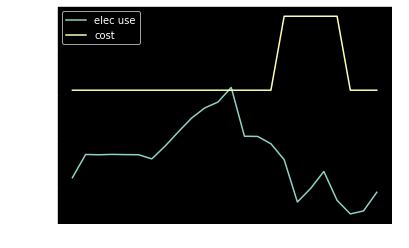

In [78]:
#plt.plot(total_normalized_cost(net_electricity_use)[0:72], label="resulting penalty")
plt.plot(net_electricity_use[-24:]/10000, label="elec use")
plt.plot(cost[-24:]/1000, label="cost")

plt.legend()

In [216]:
generations = pd.concat([building1["Solar Generation [W/kW]"].rolling(19).sum()[building1["Hour"] == 15]*4/1000,
    building2["Solar Generation [W/kW]"].rolling(19).sum()[building1["Hour"] == 15]*4/1000,
    building3["Solar Generation [W/kW]"].rolling(19).sum()[building1["Hour"] == 15]*4/1000,
    building4["Solar Generation [W/kW]"].rolling(19).sum()[building1["Hour"] == 15]*4/1000,
    building5["Solar Generation [W/kW]"].rolling(19).sum()[building1["Hour"] == 15]*4/1000]
).dropna()

In [221]:
usages = pd.concat([(building1["Solar Generation [W/kW]"]*4/1000 - building1["Equipment Electric Power [kWh]"]).rolling(5).sum()[building1["Hour"] == 20][1:],
        (building2["Solar Generation [W/kW]"]*4/1000 - building2["Equipment Electric Power [kWh]"]).rolling(5).sum()[building1["Hour"] == 20][1:],
        (building3["Solar Generation [W/kW]"]*4/1000 - building3["Equipment Electric Power [kWh]"]).rolling(5).sum()[building1["Hour"] == 20][1:],
        (building4["Solar Generation [W/kW]"]*5/1000 - building4["Equipment Electric Power [kWh]"]).rolling(5).sum()[building1["Hour"] == 20][1:],
        (building5["Solar Generation [W/kW]"]*4/1000 - building5["Equipment Electric Power [kWh]"]).rolling(5).sum()[building1["Hour"] == 20][1:]]
        )

In [261]:
ratios = pd.Series(-usages.values/generations.values)
ratios.quantile(0.8)
ratios.mean()

0.5711217432012412

In [259]:
(generations).quantile(.12)

6.458774666666666

In [205]:
(building1["Solar Generation [W/kW]"].rolling(19).sum()[building1["Hour"] == 15].count())

364

In [208]:
(building1["Solar Generation [W/kW]"]*4/1000 - building1["Equipment Electric Power [kWh]"]).rolling(5).sum()[building1["Hour"] == 20].count()

365

In [80]:
# assume no efficiency penalty

# time-shifting algorithm:
# constraints:
# 1. battery can't be more full than capacity
capacity = 6.4 #kWh
# 2. battery can't charge/discharge instantly



In [203]:
1- (3.950946666542689/15.086028333155316)

0.7381055782681054

In [387]:
soc = pd.read_csv("soc.csv", header=None)

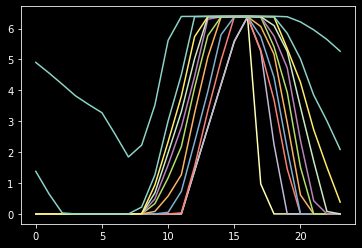

In [388]:
plt.plot(soc.groupby(lambda x : x %24).max())
for q in range(10):
    plt.plot(soc.groupby(lambda x : x %24).quantile(q/10))

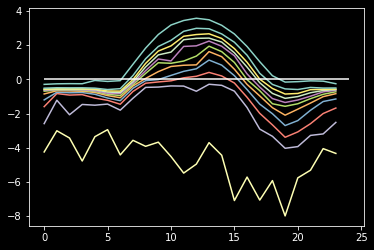

In [355]:
plt.plot(net_electricity_use.groupby(lambda x : x %24).max())

for q in range(10):
    plt.plot(net_electricity_use.groupby(lambda x : x %24).quantile(q/10))


plt.hlines(0, 0, 24)

In [319]:
(0.6684103291010868 + 0.8488546641884129)/2

0.7586324966447499

In [324]:
(0.6425981554693359 + 0.861395132269613)/2

0.7519966438694744

In [350]:
(0.6697031919378844+ 0.8577645196872606) /2

0.7637338558125726

In [356]:
(0.6520167308971867 + 0.8603654273975192)/2

0.756191079147353